In [767]:
import sys
import torch
import numpy as np
sys.path.append('../')
from wbident import PSO, Model
import matplotlib.pyplot as plt

In [1001]:
from scipy.io import loadmat
import warnings

warnings.filterwarnings('error')

In [769]:
# psup  7 × 105 Pa Supply pressure
# patm  1 × 105 Pa Atmospheric pressure
# R  287 Jkg/K Gas constant
# T  293 K Temperature of supply air
# γ  1.4 Specific heat ratio, dimensionless
# M  10.125 kg Mass
# βench  0.69501 × 10−8 Constant coefficient to fill up
# βesv  0.898105 × 10−8 Constant coefficient to deflate
# σ0  0.5 × 106 N/m Stiffness coefficient
# σ1  400 Ns/m Damping coefficient
# σ2  46.532 Ns/m Viscous friction coefficient
# Fc  23.103 N Coulomb friction force
# Fs  24 N Static friction force
# y ̇s  0.010 m/s Stribeck velocity

In [1299]:
# 1 atm = 101 325 Pa = 101,325 kPa = 1,01325 bar = 760 mmHg
class EqSystem(Model):
    def __init__(self, params=None):
        super(EqSystem, self).__init__(params)
        self._params = params

    def model(self, t, y, *args):
        Patm = 1e5                          # Pressão atmosférica
        Ps   = 4.6e5 + Patm                   # Pressão suprimento
        M = 1.323 + 0.146                   # Massa Total
        d1 = 0.025
        d2 = 0.005
        A1 = np.pi * (d1/2)**2              # Área do êmbolo
        A2 = np.pi * (d2/2)**2                         
        A2 = A2 - A1 
        Ao = A1*2                           # Área Orifício
        Vb0 = 0.056                         # Volume morto da Câmara A
        Va0 = 0.144                         # Volume morto da Câmara B
        R = 287                             # Constante universal dos gases
        T = 293                             # Temperatura do ar de suprimento
        L = 0.125                           # Curso útil do cilindro
        kv = 410                            # Coeficiente de atrito viscoso
        gamma = 1.4                         # Relação entre os calores específicos do ar
        g = 9.8                             # Força Gravitacional

        u = args[0][0]

        # k = self.unknown_const
        # # rewrite unknown variables
        # kv =    k[0]
        # A1 =    k[1]                     # Área do êmbolo
        # A2 =    k[2]
        # A3 = A1 - A2 
        # Ao =    k[3]                           # Área Orifício
        # Vb0 =   k[4]                         # Volume morto da Câmara A
        # Va0 =   k[5]                         # Volume morto da Câmara B
        # u_gain = k[6]

        # u = u * u_gain


       

        def Psi(sigma):
            if sigma > 0.528:
                # subsonic flow
                psi = np.sqrt( gamma/(gamma-1) * ((sigma)**(2/gamma) - (sigma)**((gamma+1)/gamma)) )
#                 psi = (2/(gamma+1) )**(1/(gamma-1)) * np.sqrt(gamma/(gamma+1))
            else:
                # chocked flow
                psi = (2/(gamma+1) )**(1/(gamma-1)) * np.sqrt(gamma/(gamma+1))
            return psi

        # Dynamic Model Source Valvule
        def dm1(Ao, Pc):
            if Pc < Ps:
                # charging
                sigma = Pc/Ps
                dm =   Ao*Ps*np.sqrt( 2*gamma / (R*T*(gamma-1))) * Psi(sigma)
            elif Pc > Ps:
                # discharging
                sigma = Ps/Pc
                dm = - Ao*Pc*np.sqrt( 2*gamma / (R*T*(gamma-1))) * Psi(sigma)
            else:
                dm = 0
            
            return dm

        # Dynamic Model relief valve
        def dm2(Ao, Pc):
            if Pc < Patm:
                # charging
                sigma = Pc/Patm
                print("foi")
                dm =   Ao*Patm*np.sqrt( 2*gamma / (R*T*(gamma-1))) * Psi(sigma)
            elif Pc > Patm:
                # discharging
                sigma = Patm/Pc
                dm = - Ao*Pc*np.sqrt(   2*gamma / (R*T*(gamma-1))) * Psi(sigma)
            else:
                dm = 0
            return dm
        
        dy = torch.zeros(len(self.x0),)

        dy[0] = y[1]
        dy[1] = ((y[2]*A1+y[3]*A2) - kv*y[1])/M -g
#         dy[1] = (Ps*u*A1 - kv*y[1])/M -g
        
        x_a = 0.5*L + y[0]
        VA = Va0 + A1*(x_a)
        if VA < Va0:
            VA = Va0
        # connect to    [Supply            ]   [Atm                  ]
        dy[2] = 1/(VA)*(R*T*dm1(Ao*(u), y[2]) + R*T*dm2(Ao*(1-u), y[2]) + y[2]*y[1]*A1)
        x_b = 0.5*L - y[0]
        VB = Vb0 + A2*(x_b)
        if VB < Vb0:
            VB = Vb0
        # connect to    [Supply            ]   [Atm                ]
        dy[3] = 1/(VB)*(R*T*dm1(Ao*(0), y[3]) + R*T*dm2(Ao*(0), y[3]) - y[3]*y[1]*A2)
        return dy

In [1300]:
def v2Pascal(value):
    Patm = 1e5
    gainV2P = 1000e3/10
    value = value * gainV2P + Patm
    return value 
# load data
data = loadmat('../data/teste0902_02.mat')
sample_select = 0.4
t = data['t'].reshape(-1,1)
t_len = len(t)
N = int( t_len * sample_select)
y0 = - 0.125/2 + data['desl']/1000
y0 = y0[:N,:]
u = data['atuador']
u = u[:N,:] 
pa = v2Pascal(data['press']) 
pa = pa[:N,:] 
t = t[:N,:]
ts = (t[1]-t[0])[0]
fs = 1/(ts)
fs = int(fs)
# del data

In [1301]:
params = {'optmizer': {'lowBound': [0.0,
                                    0.0,
                                    0.0,
                                    0.0,
                                    0.0,
                                    0.0,
                                    0.01],
                        'upBound': [1000,
                                    1.0,
                                    1.0,
                                    1.0,
                                    1.0,
                                    1.0,
                                    10],
                        'maxVelocity': 5, 
                        'minVelocity': -5,
                        'nPop': 5,
                        'nVar': 7,
                        'social_weight': 2,
                        'cognitive_weight': 2,
                        'w': 0.9,
                        'beta': 1,
                        'w_damping': 0.99},
            'dyn_system': {'model_path': '',
                            'external': u,
                            'state_mask' : [True, False, True, False],
                            'x0':  [y0[0,0], 
                                   (y0[1,0]-y0[0,0])/ts,
                                   pa[0,0],
                                   1e5+7],
                            't': [0,10-ts,len(t)],
                            }
            }

f_fit = EqSystem(params)

In [1302]:
out = f_fit.simulation(None)

foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi


foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi


foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi


foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi
foi


foi


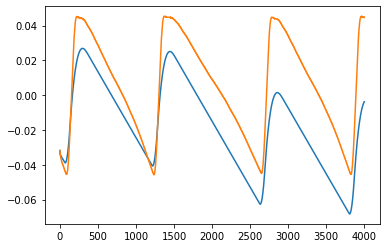

In [1303]:
plt.plot(out[:,0])
plt.plot(y0)

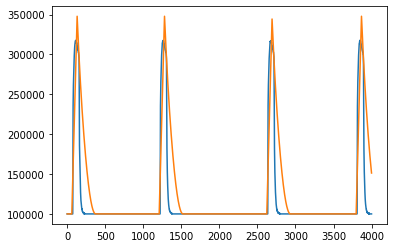

In [1304]:
plt.plot(pa)
plt.plot(out[:,2])
# plt.plot(out[:,3])

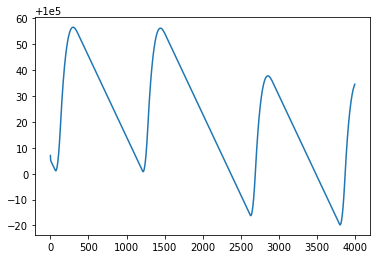

In [1297]:
plt.plot(out[:,3])

In [1298]:
# 0 ----> 1000 KPa
# 0 ----> 10v

Patm = 1e5
Ps = 2 * 1000e3/10





In [1155]:
Ps - Patm

100000.0

In [1156]:
out[:,3]


tensor([100000.0000, 100266.0312, 100258.9453,  ...,  99212.5391,
         99210.3203,  99208.1094])

In [903]:
out[-10,3]

tensor(99998.0312)

In [1058]:
def Psi(sigma):
    gamma = 1.4                         # Relação entre os calores específicos do ar

    if sigma > 0.528:
        # subsonic flow
        psi = np.sqrt( gamma/(gamma-1) * ((sigma)**(2/gamma) - (sigma)**((gamma+1)/gamma)) )

    else:
        # chocked flow
        psi = (2/(gamma+1) )**(1/(gamma-1)) * np.sqrt(gamma/(gamma+1))

    return psi

In [1059]:
Psi(0.1)

0.4841782560961086

In [1060]:
x = np.linspace(0,1, 100)
y = [Psi(i) for i in x]

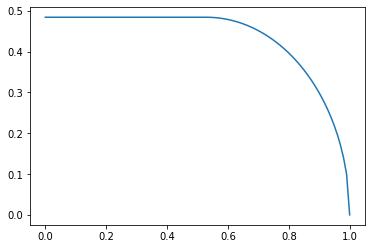

In [1061]:
plt.plot(x,y)

In [1045]:
gamma = 1.4                         # Relação entre os calores específicos do ar

gamma/(1-gamma)

-3.5000000000000004

In [1284]:
1e5

100000.0